In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow import get_logger
from tensorflow import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
from tqdm.notebook import tqdm

# Disable everything but error message from Tensorflow
get_logger().setLevel('ERROR')

In [20]:
# Load CIFAR10
def load_dataset(class_num=None):

    (X, y), (_,_) = keras.datasets.cifar10.load_data()

    # Class number randomly chosen between 1 and 10
    if class_num is None:
        class_num = np.random.randint(low=0,high=10,size=1)[0]

    X=X[y.flatten() == class_num]
    X = X.astype('float32')

    X = (X / 127.5) - 1.0

    return X, class_num

Class num 7


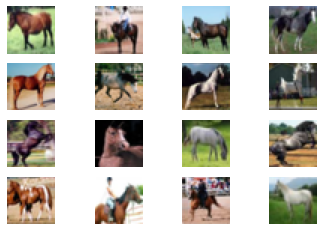

In [21]:
dataset, class_num = load_dataset(7)

# # Convert from unsigned ints to floats
# dataset = dataset.astype('float32')
# # Scaling to [-1, 1]
# dataset = (dataset-127.5)/127.5

print("Class num {}".format(class_num))

# Display some images farom selected class
r, c = 4,4
for i in range(r*c):
    image = (dataset[i] + 1) / 2.0
    plt.subplot(r, c, 1+i)
    # Turn off axis
    plt.axis('off')
    # Plot raw pixel data
    plt.imshow(image)

filename = 'control.jpg'
plt.savefig(os.path.join("plots", filename))
plt.show()
plt.close()

In [22]:
# Function to select real samples from the dataset for training discriminator
def generate_real_samples(dataset, n_samples):
    # Choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)

    # Retrieve selected images
    X = dataset[ix]

    # Generate 'real' class labels (1)
    y = np.ones((n_samples, 1))

    return X, y

In [23]:
# Generate point in latent space (noise) as input for the generator
def generate_latent_points(latent_dim, n_samples):
    latent_points = np.random.randn(latent_dim * n_samples)

    # Reshape into batch of inputs for network
    latent_points = latent_points.reshape(n_samples, latent_dim)

    return latent_points

In [24]:
# Generate n fake samples with class labels
def generate_fake_samples(generator, latent_dim, n_samples):

    latent_points = generate_latent_points(latent_dim, n_samples)
    
    # Get output from generator
    X = generator.predict(latent_points)

    # Generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))

    return X, y

In [25]:
# def build_discriminator(in_shape):
    
#     model = Sequential()

#     # Convolution layers to process images and classify whether image is real or fake
#     model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=in_shape, padding="same"))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.25))

#     model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))

#     model.add(ZeroPadding2D(padding=((0,1),(0,1))))
#     model.add(BatchNormalization(momentum=0.82))
#     model.add(LeakyReLU(alpha=0.25))
#     model.add(Dropout(0.25))

#     model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
#     model.add(BatchNormalization(momentum=0.82))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.25))

#     model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(LeakyReLU(alpha=0.25))
#     model.add(Dropout(0.25))

#     #Building the output layer
#     model.add(Flatten())
#     model.add(Dense(1, activation='sigmoid'))

#     # Compile the model
#     model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])
#     return model

#     # image = Input(shape=image_shape)
#     # validity = model(image)
#     # return Model(image, validity)

In [26]:
def build_discriminator(in_shape):

    model = Sequential()

    # normal
    model.add(Conv2D(32, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # downsample
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))

    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.25))

    # classifier
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5), metrics=['accuracy'])
    return model

In [27]:
# def build_generator(latent_dim):

#     model = Sequential()

#     # Building the input layer
#     model.add(Dense(128 * 8 * 8,activation='relu', input_dim=latent_dim))
#     model.add(Reshape((8,8,128)))

#     model.add(UpSampling2D())

#     model.add(Conv2D(128, kernel_size=3, padding="same"))
#     model.add(BatchNormalization(momentum=0.78))
#     model.add(Activation("relu"))

#     model.add(UpSampling2D())

#     model.add(Conv2D(64, kernel_size=3, padding="same"))
#     model.add(BatchNormalization(momentum=0.78))
#     model.add(Activation('relu'))

#     model.add(Conv2D(3, kernel_size=3, padding="same"))
#     model.add(Activation("tanh"))

#     return model

    # Generating the output image
    # noise = Input(shape=(latent_dimensions,))
    # image = model(noise)

    # return Model(noise, image)

In [28]:
def build_generator(latent_dim):

    model = Sequential()

    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))

    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [29]:
# Function for building combined GAN model
def build_gan(generator, discriminator):
    # Make discriminator untrainable so it doesn't update when training full GAN model
    discriminator.trainable = False # Does not impact training of standalone model

    model = Sequential()

    model.add(generator)
    model.add(discriminator)

    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002,0.5))
    return model

In [30]:
def update_discriminator(discriminator, generator, dataset, latent_dim, n_iter=20, n_batch=128):
    half_batch = int(n_batch / 2)
    
    #for i in tqdm(range(n_iter), desc="Discriminator Update", position=2):
    for i in range(n_iter):
        
        # Update discriminator on real samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        d1_loss, real_acc = discriminator.train_on_batch(X_real, y_real)

        # Update disciminator on fake smaples
        X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
        d2_loss, fake_acc = discriminator.train_on_batch(X_fake, y_fake)

        return d1_loss, d2_loss
        #tqdm.write("Discriminator Update Epoch {}: real={}%% fake={}%%".format(i+1, real_acc*100, fake_acc*100))

In [31]:
def save_plot(images, epoch, n=4):
    
    # Plot images
    for i in range(n*n):
        # Scale from [-1, 1] to [0, 1]
        image = (images[i] + 1) / 2.0

        plt.subplot(n,n,i+1)
        plt.axis('off')
        plt.imshow(image)
    
    # save plot to file
    filename = 'generated_plot_e{:03d}.jpg'.format(epoch)
    plt.savefig(os.path.join("plots", filename))
    plt.close()

In [32]:
def evaluate_performance(epoch, generator, discriminator, dataset, latent_dim, n_samples=200):

    # Evaluate discriminator on real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, real_acc = discriminator.evaluate(X_real, y_real, verbose=0)

    # Evaluate disciminator on fake smaples
    X_fake, y_fake = generate_fake_samples(generator, latent_dim, n_samples)
    _, fake_acc = discriminator.evaluate(X_fake, y_fake, verbose=0)

    # Save plot with generated images
    save_plot(X_fake, epoch)

    # Save generator model
    filename = "generator_model_{:03d}.h5".format(epoch)
    generator.save(os.path.join("models", filename))

    return real_acc, fake_acc

In [33]:
# # Function to train the discriminator
# def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, n_batch=128):
#     batches_per_epoch = int(dataset.shape[0] / n_batch)

#     #print("Trianing discriminating on valid images and random noise prior to GAN training...")
#     #update_discriminator(discriminator, generator, dataset, latent_dim, 10, n_batch)

#     for epoch in tqdm(range(n_epochs), desc="GAN Training", position=0):

#         loss = []
#         d1_loss = []
#         d2_loss = []
#             # update discriminator if either detection accuracy is less than 75%
#             #if (real_acc < 0.75) or (fake_acc < 0.75):       

#         for batch in range(batches_per_epoch):

#             d1, d2 = update_discriminator(discriminator, generator, dataset, latent_dim, 1, n_batch)
#             d1_loss.append(d1)
#             d2_loss.append(d2)

#             # Prepare points in latent space as input for gan
#             X_gan = generate_latent_points(latent_dim, n_batch)

#             # Create inverted labels for fake samples
#             y_gan = np.ones((n_batch, 1))

#             # Update the generator via the discriminator's error
#             g_loss = gan.train_on_batch(X_gan, y_gan)
#             loss.append(g_loss)
            
#             #tqdm.write("Epoch {} ({}/{}): Generator Loss={:.3f} | Discriminator Loss = {:.3f} - {:.3f}".format(epoch, batch, batches_per_epoch, g_loss, d1, d2))

#         # Summarize average loss across epoch
#         tqdm.write("Epoch {} Averages: Generator Loss={:.6f} | Discriminator Loss = {:.6f} - {:.6f}".format(epoch, np.average(loss),np.average(d1_loss), np.average(d2_loss)))

#         #update_discriminator(discriminator, generator, dataset, latent_dim, 10, n_batch)

#         if epoch % 10 == 0:
#             real_acc, fake_acc = evaluate_performance(epoch, generator, discriminator, dataset, latent_dim, 1000)
#             tqdm.write("Epoch {}: real: {}%%, fake: {}%%".format(epoch, real_acc*100, fake_acc*100))

In [34]:
# Function to train the discriminator
def train(generator, discriminator, gan, dataset, latent_dim, n_epochs=20, n_batch=128):
    batches_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch/2)

    #print("Trianing discriminating on valid images and random noise prior to GAN training...")
    #update_discriminator(discriminator, generator, dataset, latent_dim, 10, n_batch)

    for epoch in tqdm(range(n_epochs), desc="GAN Training", position=0):

        loss = []
        d1_loss = []
        d2_loss = []
            # update discriminator if either detection accuracy is less than 75%
            #if (real_acc < 0.75) or (fake_acc < 0.75):       

        for batch in range(batches_per_epoch):

            # Train discrimnator on real samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            dl1, _ = discriminator.train_on_batch(X_real, y_real)
            d1_loss.append(dl1)

            # Train discriminator on fake samples
            X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
            dl2, _ = discriminator.train_on_batch(X_fake, y_fake)
            d2_loss.append(dl2)

            # Prepare points in latent space as input for gan
            X_gan = generate_latent_points(latent_dim, n_batch)

            # Create inverted labels for fake samples
            y_gan = np.ones((n_batch, 1))

            # Update the generator via the discriminator's error
            g_loss = gan.train_on_batch(X_gan, y_gan)
            loss.append(g_loss)
            
            #tqdm.write("> {} ({}/{}): G={:.6f} | D ={:.6f} - D2={:.6f}".format(epoch+1, batch+1, batches_per_epoch, g_loss, dl1, dl2))

        # Summarize average loss across epoch
        tqdm.write("*> Epoch {}: Generator Loss={:.6f} | Discriminator Loss = {:.6f} - {:.6f}".format(epoch+1, np.average(loss),np.average(d1_loss), np.average(d2_loss)))

        #update_discriminator(discriminator, generator, dataset, latent_dim, 10, n_batch)

        if ((epoch+1) % 10 == 0) or (epoch == 0):
            real_acc, fake_acc = evaluate_performance(epoch+1, generator, discriminator, dataset, latent_dim, 100)
            tqdm.write("Evaluation > Epoch {}: real: {}%, fake: {}%".format(epoch+1, real_acc*100, fake_acc*100))

In [35]:
image_shape = (32, 32, 3)
latent_dimensions = 100
dataset,_ = load_dataset(7)

discriminator_model = build_discriminator(image_shape)
generator_model = build_generator(latent_dimensions)
gan_model = build_gan(generator_model, discriminator_model)

In [36]:
train(generator_model, discriminator_model, gan_model, dataset, latent_dimensions, 200, 128)

GAN Training:   0%|          | 0/200 [00:00<?, ?it/s]

*> Epoch 1: Generator Loss=0.775571 | Discriminator Loss = 0.287249 - 0.760449
Evaluation > Epoch 1: real: 100.0%, fake: 99.00000095367432%
*> Epoch 2: Generator Loss=1.314733 | Discriminator Loss = 0.187101 - 0.535398
*> Epoch 3: Generator Loss=2.394330 | Discriminator Loss = 0.322400 - 0.445745
*> Epoch 4: Generator Loss=2.878408 | Discriminator Loss = 0.411307 - 0.314321
*> Epoch 5: Generator Loss=1.974996 | Discriminator Loss = 0.416729 - 0.378150
*> Epoch 6: Generator Loss=2.397444 | Discriminator Loss = 0.373849 - 0.288028
*> Epoch 7: Generator Loss=2.092065 | Discriminator Loss = 0.657870 - 0.428500
*> Epoch 8: Generator Loss=1.653292 | Discriminator Loss = 0.436624 - 0.381001
*> Epoch 9: Generator Loss=1.753824 | Discriminator Loss = 0.574265 - 0.438958
*> Epoch 10: Generator Loss=1.660173 | Discriminator Loss = 0.811138 - 0.431745
Evaluation > Epoch 10: real: 68.99999976158142%, fake: 92.00000166893005%
*> Epoch 11: Generator Loss=1.211597 | Discriminator Loss = 0.632754 - 0.5

KeyboardInterrupt: 